In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/tcapelle/aws_smsl_demo/blob/main/02_semantic_segmentation.ipynb.ipynb)

# Train a Baseline

The model is supposed to learn a per-pixel annotation of a scene captured from the point of view of the autonomous agent. The model needs to categorize or segment each pixel of a given scene into 32 relevant categories such as road, pedestrian, sidewalk, cars etc. like listed below. You can click on any of the segmented images on the table shown above and access this interactive interface for accessing the segmentation result and categories.

![](images/camvid_mask.gif)

For the baseline experiments we decided to use a simple architecture inspired by the `UNet` with a `ResNet50`, `VGG19` and `MobileNetV2` backbone which in-spite being quite easy to implement is also quite robust with respect to its performance. We also incorporated the Chained Residual Pooling Layer as proposed by the creators of the RefineNet architecture, so that our model is able to capture background context from a large image region by efficiently pooling features with multiple window sizes and fusing them together with residual connections and learnable weights. 

We performed the baseline experiments with `Focal Loss`. We attach a brief summary of our experiments with the baseline models and the loss functions.

> We will need a `GPU` backend for this notebooks, we can check using `nvidia-smi` command like this

In [2]:
!nvidia-smi

Wed Mar  9 17:33:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import wandb
import torch
from fastai.vision.all import *
from typing import List, Union, Tuple
from fastai.callback.wandb import WandbCallback

from segmentation.metrics import *
from segmentation.model import SegmentationModel
from segmentation.train_utils import benchmark_inference_time, save_model_to_artifacts

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


we will define some parameters to pass to our config and baseline

In [4]:
# wandb params
PROJECT="sagemaker_camvid_demo"
ENTITY=None

# hyper params
IMAGE_SHAPE = (720, 960)

BACKBONE = "resnet50"
SEED = 42

RUN_NAME = f"final-fit-{BACKBONE}"
JOB_TYPE = "train"

ARTIFACT_ID = "camvid-dataset:latest"

BATCH_SIZE = 8
IMAGE_RESIZE_FACTOR = 2
VALIDATION_SPLIT_PCT = 0.2
HIDDEN_DIM = 256


LEARNING_RATE = 0.00065
TRAIN_EPOCHS = 15
WEIGHT_DECAY = 0.01
USE_AUGMENTATION = False

INFERENCE_BATCH_SIZE = 4
NUM_WARMUP_ITERS = 10
NUM_INFERENCE_BENCHMARK_ITERS = 100

In [5]:
set_seed(SEED)

In [6]:
run = wandb.init(
    project=PROJECT,
    name=RUN_NAME,
    entity=ENTITY,
    job_type=JOB_TYPE,
    config={
        "artifact_id": ARTIFACT_ID,
        "image_shape": IMAGE_SHAPE,
        "batch_size": BATCH_SIZE,
        "image_resize_factor": IMAGE_RESIZE_FACTOR,
        "validation_split": VALIDATION_SPLIT_PCT,
        "hidden_dims": HIDDEN_DIM,
        "backbone": BACKBONE,
        "learning_rate": LEARNING_RATE,
        "train_epochs": TRAIN_EPOCHS,
        "inference_batch_size": INFERENCE_BATCH_SIZE,
        "num_warmup_iters": NUM_WARMUP_ITERS,
        "num_inference_banchmark_iters": NUM_INFERENCE_BENCHMARK_ITERS,
        "augmentations":USE_AUGMENTATION,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape (use `wandb login --relogin` to force relogin)


## DataLoader for SegmentationDataLoader for Segmentation

In [7]:
def label_func(fn):
    return fn.parent.parent/"labels"/f"{fn.stem}_P{fn.suffix}"


def get_dataloaders(
    artifact_id: str, # the name of the artifact
    batch_size: int,  # the batch size for training, 2x for val
    resize_factor: int, # a integer resize factor for training
    validation_split_pct: float, # the validation percentage of data to be used in [0,1] 
    augment: bool, # use augmentations
    seed: int, # the seed
):
    """Grab an artifact and creating a Pytorch DataLoader"""
    artifact = wandb.use_artifact(artifact_id, type='dataset')
    artifact_dir = Path(artifact.download())
    codes = np.loadtxt(artifact_dir/'codes.txt', dtype=str)
    fnames = get_image_files(artifact_dir/"images")
    class_labels = {k: v for k, v in enumerate(codes)}
    
    image_shape = load_image(fnames[0]).shape
    
    tfms = aug_transforms()
    
    return SegmentationDataLoaders.from_label_func(
        artifact_dir,
        bs=batch_size,
        fnames=fnames,
        label_func=label_func,
        codes=codes,
        item_tfms=Resize((
            image_shape[0] // resize_factor,
            image_shape[1] // resize_factor
        )),
        batch_tfms=tfms if augment else None,
        valid_pct=validation_split_pct,
        seed=seed
    ), class_labels

wandb: Downloading large artifact camvid-dataset:latest, 572.51MB. 1405 files... Done. 0:0:0


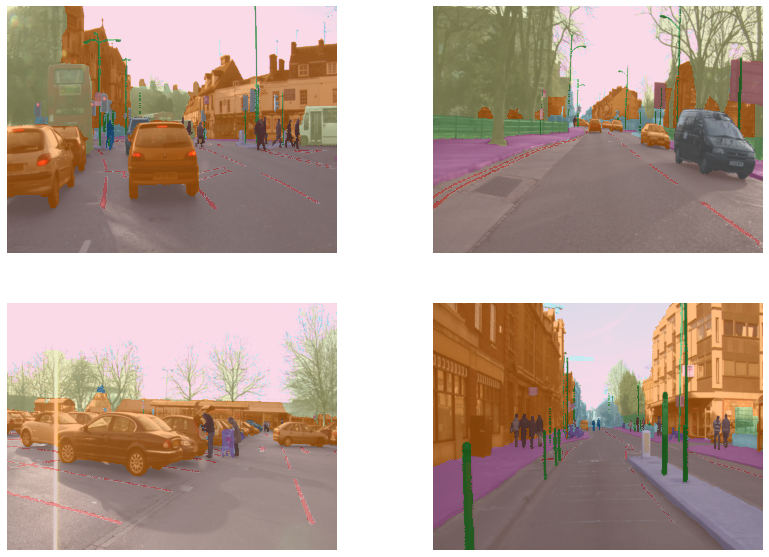

In [8]:
data_loader, class_labels = get_dataloaders(
    artifact_id=ARTIFACT_ID,
    batch_size=BATCH_SIZE,
    resize_factor=IMAGE_RESIZE_FACTOR,
    validation_split_pct=VALIDATION_SPLIT_PCT,
    augment=USE_AUGMENTATION,
    seed=SEED
)

data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Training and Inference

Let's log a bunch of useful data for model evaluation

In [9]:
def get_model_parameters(model):
    "Get total number of model params"
    with torch.no_grad():
        num_params = sum(p.numel() for p in model.parameters())
    return num_params

In [10]:
def get_predictions(learn, test_dl=None, max_n=None):
    "Return the samples = (x,y) and outputs (model predictions decoded), and predictions (raw preds)" 
    if test_dl is None:
        test_dl = learn.dls.valid
    inputs, predictions, targets, outputs = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)
    x, y, samples, outputs = learn.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=max_n
    )
    return samples, outputs, predictions

In [11]:
def get_learner(
    data_loader,
    backbone: str,
    hidden_dim: int,
    num_classes: int,
    checkpoint_file: Union[None, str, Path],
    loss_func,
    metrics: List,
    log_preds: bool = False
):
    model = SegmentationModel(backbone, hidden_dim, num_classes=num_classes)
    mixed_precision_callback = MixedPrecision()
    wandb_callback = WandbCallback(log_model=False, log_preds=log_preds)
    learner = Learner(
        data_loader,
        model,
        loss_func=loss_func,
        metrics=metrics,
        cbs=[mixed_precision_callback, wandb_callback],
    )
    if checkpoint_file is not None:
        load_model(checkpoint_file, learner.model, opt=None, with_opt=False)
        # learner.load(checkpoint_file)
    return learner

In [12]:
learn = get_learner(
    data_loader,
    backbone=BACKBONE,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(class_labels),
    checkpoint_file=None,
    loss_func=FocalLossFlat(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    log_preds=False,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


## Log preds

In [13]:
def table_from_dl(learn, test_dl, class_labels):
    samples, outputs, predictions = get_predictions(learn, test_dl)
    table = create_dice_table(samples, outputs, predictions, class_labels)
    return table

In [14]:
learn.fit_one_cycle(TRAIN_EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,1.723034,0.852012,0.151273,0.772921,01:06


RuntimeError: CUDA out of memory. Tried to allocate 676.00 MiB (GPU 0; 14.76 GiB total capacity; 11.90 GiB already allocated; 341.75 MiB free; 13.51 GiB reserved in total by PyTorch)

In [ ]:
# if accuracy is greater than 90% send an alert
accuracy_value = learn.recorder.metrics[1].value
if accuracy_value > .90:
    wandb.alert(title=f"Training Succesuful: accuracy={accuracy_value:.3f}", 
                text=f"After {TRAIN_EPOCHS}: run: {wandb.run.name} epochs succesuful")

In [ ]:
pred_table = table_from_dl(learn, learn.dls.valid, class_labels)

In [ ]:
wandb.log({f"Predictions_Table": pred_table})

## Save models

In [ ]:
save_model_to_artifacts(
    learn.model, 
    f"Unet_{BACKBONE}", 
    image_shape=IMAGE_SHAPE,
    artifact_name=f"{run.name}-saved-model",
    metadata={
        "backbone": BACKBONE,
        "hidden_dims": HIDDEN_DIM,
        "input_size": IMAGE_SHAPE,
        "class_labels": class_labels
    }
)

In [ ]:
wandb.finish()